In [ ]:
! pip install -U segmentation_models_pytorch==0.3.0
! pip install -U timm==0.8.0.dev0
! pip install opencv-python
! pip install matplotlib
#!conda install pytorch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 cudatoolkit=11.3 -c pytorch -c conda-forge

In [1]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np

import segmentation_models_pytorch
import torch

C:\Users\numan\anaconda3\envs\blur_face\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def cpu_segment_img(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    ## Preprocess the image
    image = segmentation_models_pytorch.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)(image)
    image = cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
    img_t = image.transpose(2, 0, 1).astype('float32')
    x_tensor = torch.from_numpy(img_t).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    return (image, pr_mask.squeeze().cpu().numpy().round())
def cpu_segment_video(video_path, segmented_video_path="segmented_video.mov", bg_img_path=None):
    start_time = time.time()
    cap = cv2.VideoCapture(video_path)
    # get the number of frames in the video
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Number of frames in the video: {frame_count}")

    # read the first frame
    success, frame = cap.read()

    height, width, channels = frame.shape
    # create a video writer object
    video_writer = cv2.VideoWriter(segmented_video_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
    bg_image = np.zeros((height, width, 3), dtype = np.uint8)
    if bg_img_path:
        bg_image = cv2.imread(bg_img_path)
        bg_image = cv2.cvtColor(cv2.resize(bg_image, (width, height)), cv2.COLOR_RGB2BGR)
    while success:
        # convert the color space to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = segmentation_models_pytorch.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)(frame_rgb.copy())
        image = cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        img_t = image.transpose(2, 0, 1).astype('float32')
        x_tensor = torch.from_numpy(img_t).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().numpy().round())

        # apply the mask to the image
        pr_mask = cv2.resize(pr_mask, (frame_rgb.shape[1],frame_rgb.shape[0]))
        img_masked = np.where(np.expand_dims(pr_mask.astype('uint8'), axis=2), frame_rgb,bg_image)
        video_writer.write(cv2.cvtColor(img_masked, cv2.COLOR_RGB2BGR))

        # read the next frame
        success, frame = cap.read()
    print(f"Process FPS: {frame_count/(time.time()-start_time):.2f} a image process time:{((time.time()-start_time)/frame_count):.2f} seconds")
    print(f"Total time speend for the video: {(time.time()-start_time):.2f} seconds")
    # release the video file
    cap.release()
    # release the video writer object
    video_writer.release()
    print(f"Segmented video is saved {segmented_video_path}")


In [3]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def merge_image_with_seg(image,mask):
    plt.figure(figsize=(16, 5))
    # plot the first image
    plt.imshow(image)

    # plot the second image on top of the first image
    plt.imshow(mask, alpha=0.5)
    
    plt.xticks([])
    plt.yticks([])

    # display the plot
    plt.show()

In [4]:
video_path = "" # path to segment a video clip
bg_img_path = None # if none back ground will be black
segmented_video_path = "" #new video will be generated in this path
image_path = "" # path to image to be segmented
model_path = "" # path to weights
##Settings
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
DEVICE = 'cpu'

In [ ]:
preprocessing_fn = segmentation_models_pytorch.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
best_model = torch.load(model_path, map_location=torch.device('cpu'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


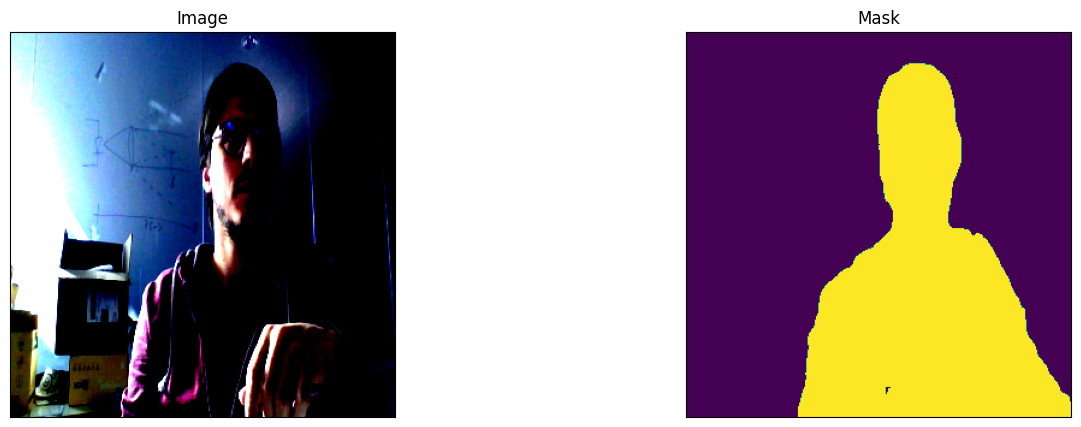

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


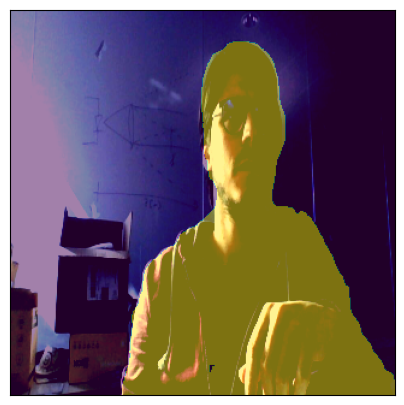

In [5]:
### Segment given image:
org_img, masked_img = cpu_segment_img(image_path)
visualize(
    image=org_img, 
    mask=masked_img,
)
merge_image_with_seg(org_img,masked_img)

In [9]:
####Segment given video and generate new segmented video
cpu_segment_video(video_path=video_path,
                  segmented_video_path=segmented_video_path,
                  bg_img_path=bg_img_path)

Number of frames in the video: 452
Process FPS: 13.87 a image process time:0.07 seconds
Total time speend for the video: 32.58 seconds
